In [14]:
from langchain_core.messages import SystemMessage, ToolMessage, AIMessage, HumanMessage
from langchain_mistralai import ChatMistralAI
from langgraph.graph import StateGraph, START, END

from typing_extensions import TypedDict
import os
import uuid
from typing import Dict

from dotenv import load_dotenv
load_dotenv()

True

In [15]:
os.environ['MISTRAL_API_KEY'] = os.getenv('MISTRAL_API_KEY')

model = "mistral-small-latest"
llm = ChatMistralAI(
    model=model,
    temperature=0,
    max_retries=5
)

In [16]:
sys_prompt = "You are a helpful assistant that solves math problems."
hum_prompt = "Solve 2x+3=7 for x."

# Invoke LLM
response = llm.invoke([
    SystemMessage(content=sys_prompt),
    HumanMessage(content=hum_prompt)]
).content.strip()

print(response)

To solve the equation 2x + 3 = 7 for x, follow these steps:

1. Subtract 3 from both sides of the equation:
   2x + 3 - 3 = 7 - 3
   2x = 4

2. Divide both sides by 2:
   2x / 2 = 4 / 2
   x = 2

So, the solution is x = 2.


In [17]:
# State definition
class State(TypedDict):
    messages: Dict

In [18]:
def read_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

In [19]:
cv_path = "data/cv.txt"
job_path = "data/job_description.txt"
start_state = {"messages": {"cv_path": cv_path, "job_path": job_path}}

In [20]:
def get_cv_content(state: dict): 
    print("***** get_cv_content *****")

    cv_path = state['messages']['cv_path']
    cv_content = read_file(cv_path)

    tool_call = ToolMessage(
        content=cv_content,
        tool_call_id=str(uuid.uuid4())
    )

    new_state = {
        "messages": {
            "job_path": state['messages']['job_path'],
            "cv_content": tool_call
        }
    }
    return new_state

In [21]:
def get_job_description(state: dict):
    print("***** get_job_description *****")

    job_path = state['messages']['job_path']

    job_content = read_file(job_path)

    tool_call = ToolMessage(
        content=job_content,
        tool_call_id=str(uuid.uuid4())
    )

    new_state = {
        "messages": {
            "cv_content": state['messages']['cv_content'],
            "job_content": tool_call
        }
    }
    return new_state

In [22]:
def evaluate_match(state: dict): # The state here will be the get_job_description result -> {"messages": {"cv_content": ___, "job_content": ___}}
    print("***** evaluate_match *****")

    # Extract the CV and job description content from the state
    cv_content = state["messages"]["cv_content"].content
    job_content = state["messages"]["job_content"].content

    # Create the evaluation prompts
    hum_evaluation_template = """CV:
    {cv}
    ===
    Job Description:
    {job}
    ===
    Evaluate whether the CV aligns with the job description provided. Clearly indicate the degree of match and provide specific reasons for your assessment, ensuring a detailed and professional response:
    """
    hum_evaluation_prompt = hum_evaluation_template.format(cv=cv_content, job=job_content)
    sys_evaluation_prompt = """You are tasked with evaluating whether the CV aligns with the job description provided. Clearly indicate the degree of match and provide specific, detailed reasons for your assessment."""

    # Invoke the LLM with the evaluation prompts
    response = llm.invoke([SystemMessage(content=sys_evaluation_prompt),
                           HumanMessage(content=hum_evaluation_prompt)])
    content = response.content.strip()

    # Create an AIMessage object with the evaluation response and a unique AI call ID
    ai_call = AIMessage(
        content=content,
        ai_call_id=str(uuid.uuid4())
    )

    # Update the state with the evaluation response
    new_state = {
        "messages": {
            "evaluation": ai_call
        }
    }
    return new_state

In [23]:
def generate_email(state: dict):
    print("***** generate_email *****")

    evaluation_result = state["messages"]["evaluation"].content

    hum_email_template = """Job Application Evaluation:
    {evaluation}
    ===
    Based on the evaluation of the match between the candidate's CV and the job description, draft an email to the candidate communicating the result of the assessment. Clearly indicate whether or not the candidate has been selected for the position and provide the reasons for the decision. Ensure the tone is polite, professional, and respectful, starting the email with a courteous acknowledgment.
    Email:
    """
    hum_email_prompt = hum_email_template.format(evaluation=evaluation_result)
    sys_email_prompt = """You are a hiring manager tasked with drafting an email to a candidate regarding the result of their job application assessment. Clearly communicate whether the candidate has been selected for the position, and provide reasons for the decision. Maintain a polite, professional, and respectful tone, starting the email with a courteous acknowledgment."""

    response = llm.invoke([SystemMessage(content=sys_email_prompt),
                           HumanMessage(content=hum_email_prompt)])
    content = response.content.strip()

    ai_call = AIMessage(
        content=content,
        ai_call_id=str(uuid.uuid4())
    )

    new_state = {
        "messages": {
            "email": ai_call
        }
    }

    return new_state

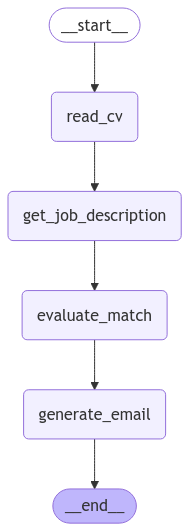

In [24]:
workflow = StateGraph(State)

# We add the nodes that corresponds to the functions we defined. We have to give them a name
workflow.add_node("read_cv", get_cv_content)
workflow.add_node("get_job_description", get_job_description)
workflow.add_node("evaluate_match", evaluate_match)
workflow.add_node("generate_email", generate_email)

workflow.add_edge(START, "read_cv")
workflow.add_edge("read_cv", "get_job_description")
workflow.add_edge("get_job_description", "evaluate_match")
workflow.add_edge("evaluate_match", "generate_email")
workflow.add_edge("generate_email", END)

graph = workflow.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
for output in graph.stream(start_state):
    print("Current Output:", output)

print("\n***** Process completed successfully!! *****\n")
print(output['generate_email']['messages']['email'].content)

***** get_cv_content *****
Current Output: {'read_cv': {'messages': {'job_path': 'data/job_description.txt', 'cv_content': ToolMessage(content='JOHN DOE\nSoftware Engineer\njohn.doe@email.com | (555) 123-4567 | linkedin.com/in/johndoe | github.com/johndoe\n\nSUMMARY\nExperienced software engineer with 5 years of expertise in machine learning and AI applications.\nProficient in Python, Java, and cloud technologies with a track record of delivering scalable\nsolutions and optimizing system performance.\n\nSKILLS\n• Programming Languages: Python, Java, JavaScript, SQL, C++\n• Frameworks & Libraries: TensorFlow, PyTorch, scikit-learn, Flask, React\n• Cloud & DevOps: AWS, Docker, Kubernetes, CI/CD pipelines\n• Machine Learning: NLP, Computer Vision, Predictive Analytics\n• Database: PostgreSQL, MongoDB, Redis\n\nPROFESSIONAL EXPERIENCE\n\nSenior Machine Learning Engineer | TechInnovate Inc. | 2021-Present\n• Developed and deployed ML models that improved customer recommendation accuracy by 